In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
!pip install openpyxl

In [2]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]

In [3]:
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
test_tree = DecisionTreeClassifier().fit(X=max_elemental.drop(['class'],axis=1),
                                          y=max_elemental['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_
df_imp_feat = pd.DataFrame(np.hstack((imp_feat.reshape(imp_feat.shape[0],1),names_feat.reshape(imp_feat.shape[0],1))))
df_imp_feat.columns = ['features', 'name']
df_imp_feat = df_imp_feat.sort_values('features', ascending=False)

df_diff_z = df_imp_feat[df_imp_feat['features'] != 0]


failed = list_failed['MAX']
failed = list(failed)

for i in max_elemental.index:
    if i in failed:
        max_elemental.loc[i,'class'] = -1


number_of_atoms = np.empty(n_samples)
compteur = 0
for element in max_elemental.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1


columns_name = max_elemental.columns.copy()
normalized = max_elemental.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(n_samples,1)
max_elem_norm = pd.DataFrame(normalized)
max_elem_norm['class'] = max_elemental['class'].copy()
max_elem_norm.columns = columns_name
max_elem_norm['compound_name'] = max_elemental.index
max_elem_norm = max_elem_norm.set_index('compound_name',drop=True)

max_elem_norm['class'] = max_elemental['class'].copy()
list_of_imp_names = list(df_diff_z['name'])
list_of_imp_names.append('label')
list_of_imp_names.append('class')
max_elem_norm = max_elem_norm.filter(items=list_of_imp_names, axis=1)


In [4]:
max_elem_norm['label'] = np.empty(n_samples)
for i in max_elem_norm.index:
    if max_elem_norm.loc[i,'class'] == 1:
        max_elem_norm.loc[i,'label'] = 1
    else:
        max_elem_norm.loc[i,'label'] = 0

positive_samples = max_elem_norm[max_elem_norm['label'] == 1]
unlabelled_samples = max_elem_norm[max_elem_norm['label'] == 0]

In [5]:
n_positives = positive_samples.shape[0]
negative_set = unlabelled_samples.sample(n=n_positives,random_state=1)
learning_set = pd.concat([positive_samples,negative_set])


In [6]:
#try with t=50
compteur = 0
error_rate_positive = np.zeros(positive_samples.shape[0])
diff_steps = max_elem_norm.filter(items=['class'],axis=1)
for element in positive_samples.index:
    training_positive = positive_samples.drop(index=element)
    training_negative = unlabelled_samples.sample(n=training_positive.shape[0])
    whole_training = pd.concat([training_positive,training_negative])
    clf = BaggingClassifier(n_estimators=50).fit(X=whole_training.drop(['class', 'label'],axis=1).to_numpy(),
                                                y=whole_training['label'].to_numpy())
    to_test = positive_samples.loc[element,:].drop(['class','label']).to_numpy().reshape(1,-1)
    error_rate_positive[compteur] = clf.predict(to_test)[0]
    trained_on = whole_training.index
    tested_on = max_elem_norm.drop(index=trained_on)
    tested_on[f'score_{compteur}'] = clf.predict(X=tested_on.drop(['class','label'],axis=1).to_numpy())
    score_of_it = pd.DataFrame(tested_on[f'score_{compteur}'])
    diff_steps = diff_steps.merge(score_of_it, how='left', left_index=True, right_index=True)
    compteur += 1

In [7]:
diff_steps.loc[failed,:].mean(axis=1)

compound_name
Mn2GaC    0.0000
Cr2AlC    0.8125
Mo2GaC    0.0000
dtype: float64

In [8]:
recall = np.sum(error_rate_positive)/positive_samples.shape[0]

In [9]:
results_k_fold = np.empty(15)
for i in range(15):
    results_k_fold[i] = diff_steps[f'score_{i}'].sum()

In [10]:
test_weird_metric = np.ones(positive_samples.shape[0])*recall
test_weird_metric = (recall**2)/(results_k_fold/n_samples)

In [11]:
test_weird_metric

array([2.733603  , 2.10095567, 2.62732901, 1.93087831, 2.55021663,
       1.6942247 , 1.84590794, 2.10823801, 2.79003058, 2.82896124,
       2.27374455, 1.58186389, 2.67941263, 1.37142428, 2.57178295])

## Testing

In [12]:
first_results = pd.DataFrame(diff_steps.drop(['class'], axis=1).sum(axis=1).sort_values(ascending=False))
first_results.columns = ['score']
superior_to_z = first_results[first_results['score'] != 0]
superior_to_z.shape[0]
above_average = first_results[first_results['score'] >=8]
almost_full_pos_pred = first_results[first_results['score'] >= 14]
most_probable_fifty_pred = list(almost_full_pos_pred.index)
max_calculated = max_calculated.set_index(keys='prettyformula',drop=True)
retained_ones_fifty = max_calculated.filter(items=most_probable_fifty_pred, axis=0)
to_plot_fifty = retained_ones_fifty['dH'].to_numpy()

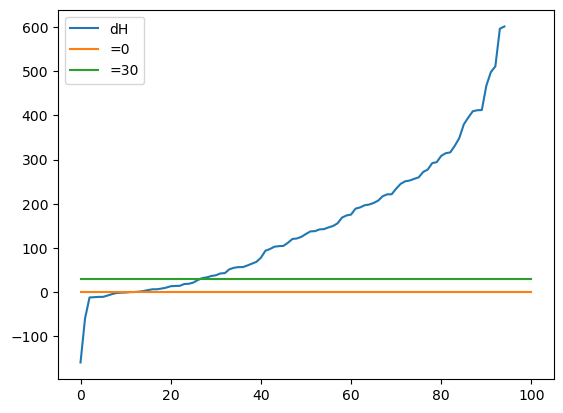

In [25]:
plt.plot(np.sort(to_plot_fifty),label='dH')
plt.plot(np.linspace(0,100,3),np.zeros(3),label='=0')
plt.plot(np.linspace(0,100,3), np.ones(3)*30,label='=30')
plt.legend()

In [14]:
very_much_probable_ones = retained_ones_fifty[retained_ones_fifty['dH'] < 0].index

In [15]:
very_much_probable_ones

Index(['Zr3AlC2', 'Nb3AlC2', 'Ti4AlC3', 'Ti3PC2', 'Hf4AlN3', 'Sc2SC', 'Cr2AlC',
       'Hf3AlC2', 'Ta3AlC2', 'Hf4AlC3', 'V2PC'],
      dtype='object')

In [16]:
recall

0.7333333333333333

In [17]:
superior_to_z.shape[0]

1487

In [18]:
above_average.shape[0]

506

In [19]:
almost_full_pos_pred.shape[0]

95

In [20]:
most_probable_fifty_pred

['Nb3PC2',
 'Zr3AlC2',
 'Mo3AlC2',
 'Mo3SiC2',
 'Mo3PC2',
 'Nb3AlC2',
 'Ti4AlC3',
 'Mo4AlN3',
 'Mo2AlC',
 'Cr4AlC3',
 'Mn4AlC3',
 'Fe4AlC3',
 'Nb3SiC2',
 'Zr2AlC',
 'W4AlC3',
 'Sc2AlN',
 'Y2AlC',
 'Ta4AlN3',
 'V3SiC2',
 'Cr3AlC2',
 'Cr3SiC2',
 'Cr3PC2',
 'Sc2PC',
 'W4AlN3',
 'W2AlC',
 'Sc3PC2',
 'Mo4AlC3',
 'V4AlN3',
 'Hf2AlC',
 'Ti2PC',
 'Cr3CuC2',
 'Sc3SiC2',
 'Cr4AlN3',
 'Sc2AlC',
 'Ti3CuC2',
 'Mn4AlN3',
 'Ti3SC2',
 'Nb4AlN3',
 'V4GaC3',
 'Ti3PC2',
 'Sc3AlC2',
 'Ti3AlN2',
 'Fe2AlC',
 'Zr2AlN',
 'Ta2AlN',
 'Hf2AlN',
 'Hf4AlN3',
 'Ta4PC3',
 'W4PC3',
 'V2AlN',
 'Y2AlN',
 'Nb2AlN',
 'Fe4AlN3',
 'Cr3ZnC2',
 'V3AlC2',
 'Os2AlC',
 'Mn3PC2',
 'Sc3ZnC2',
 'Sc2SC',
 'Sc2SiC',
 'Re2AlC',
 'Sc2ZnC',
 'Ti2SiC',
 'Fe3PC2',
 'Fe3SiC2',
 'Fe3AlC2',
 'Y3PC2',
 'Zr3SiC2',
 'Zr3PC2',
 'Y3SiC2',
 'Y3AlC2',
 'Cr2AlC',
 'Ru2AlC',
 'Hf3AlC2',
 'Mn2AlC',
 'W3AlC2',
 'Ta3AlC2',
 'Ti4PC3',
 'Hf4AlC3',
 'V4CuC3',
 'V4ZnC3',
 'V2PC',
 'Ti4PN3',
 'Cr4PC3',
 'Mn4PC3',
 'Mn3SiC2',
 'Fe4PC3',
 'Mn3AlC2',
 'Nb4PC3'